In [1]:
!pip3 install influxdb-client
!pip3 install tensorflow
!pip3 install pandas
!pip3 install numpy
!pip3 install sklearn
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install keras
# brew install libomp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 744.1/744.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.8/217.8 kB 22.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
!pip3 install scalecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 87.7 MB/s eta 0:00:00
  Created wheel for scalecast: filename=SCALECAST-0.19.8-py3-none-any.whl size=125274 sha256=32e0343d65948d3edca49f5076de6c5ccb4333e9bcde925a81da3a88800ce0fe
  Stored in directory: /root/.cache/pip/wheels/ac/67/2e/0244bcec7f41d76aae4c4196b64d31a20d474a7d5468f3d67e
Successfully built scalecast
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import keras
from influxdb_client import InfluxDBClient, Point, WriteOptions
from influxdb_client.client.warnings import MissingPivotFunction
from sklearn.model_selection import train_test_split
from scalecast.Forecaster import Forecaster
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import time
import warnings
sns.set(rc={'figure.figsize':(25,8)})

In [240]:
# Reading data from DB

# InfluxDB credentials and details
url = "http://kammeyer.uk:8086"
token = "9V1NYZbTXZkbf9H0Szf8Gl-dOaqrl97TmdC9gwNhxkRCgAcHR7jGSxnPtwHq2vBL-UOd607yPlROxlJAhRAwqw=="
org = "messme"

# Initialize InfluxDB Client
client = InfluxDBClient(url=url, token=token, org=org)

# Define the query for the 'energy' bucket
query = """
from(bucket: "energy")
  |> range(start: -2y, stop: 2023-04-15T00:00:00Z )
  |> filter(fn: (r) => r._measurement == "energy_production")
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
"""


# Fetch data into a DataFrame
start = time.time()
df = client.query_api().query_data_frame(query=query)
end = time.time()
print("Time taken to read the data is : ", end-start)
df.tail()

Time taken to read the data is :  13.254958391189575


,result,table,_start,_stop,_time,_measurement,region,Biomasse,Braunkohle,Erdgas,Kernenergie,Photovoltaik,Pumpspeicher,Sonstige Erneuerbare,Sonstige Konventionelle,Steinkohle,Wasserkraft,Wind Offshore,Wind Onshore
41722,_result,0,2022-02-04 08:08:17.475398+00:00,2023-04-15 00:00:00+00:00,2023-04-14 22:45:00+00:00,energy_production,DE,1117.75,2696.50,1296.75,645.75,0.0,366.00,39.25,321.25,1081.00,366.25,561.00,1557.75
41723,_result,0,2022-02-04 08:08:17.475398+00:00,2023-04-15 00:00:00+00:00,2023-04-14 23:00:00+00:00,energy_production,DE,1114.50,2669.50,1277.00,645.75,0.0,402.75,39.25,321.25,1022.00,365.75,555.75,1541.25
41724,_result,0,2022-02-04 08:08:17.475398+00:00,2023-04-15 00:00:00+00:00,2023-04-14 23:15:00+00:00,energy_production,DE,1113.00,2639.50,1277.25,646.00,0.0,377.50,39.00,322.50,975.25,365.75,532.75,1535.25
41725,_result,0,2022-02-04 08:08:17.475398+00:00,2023-04-15 00:00:00+00:00,2023-04-14 23:30:00+00:00,energy_production,DE,1109.00,2635.50,1272.00,645.75,0.0,296.75,39.00,322.50,938.50,366.50,500.25,1544.25
41726,_result,0,2022-02-04 08:08:17.475398+00:00,2023-04-15 00:00:00+00:00,2023-04-14 23:45:00+00:00,energy_production,DE,1113.50,2629.75,1256.75,645.75,0.0,326.50,39.25,321.75,869.25,367.00,467.50,1558.00


In [241]:
# drop extra columns
columns_to_drop = ['result', '_start', '_stop', '_measurement', 'region']
df = df.drop(columns=columns_to_drop, inplace=False)

In [242]:
# Set index
df['_time'] = pd.to_datetime(df['_time'])
df = df.set_index('_time')

In [243]:
# Sort the DataFrame by index
df = df.sort_index()

In [244]:
df.tail(100)

,table,Biomasse,Braunkohle,Erdgas,Kernenergie,Photovoltaik,Pumpspeicher,Sonstige Erneuerbare,Sonstige Konventionelle,Steinkohle,Wasserkraft,Wind Offshore,Wind Onshore
_time,,,,,,,,,,,,,
2023-04-13 23:00:00+00:00,0,1091.75,2953.75,1451.75,657.25,0.0,105.75,37.75,320.50,1395.00,354.75,1206.00,678.75
2023-04-13 23:15:00+00:00,0,1090.50,2959.50,1441.75,657.75,0.0,23.00,38.00,319.00,1386.50,356.75,1158.50,714.75
2023-04-13 23:30:00+00:00,0,1093.50,2947.25,1423.50,657.50,0.0,33.00,38.00,317.00,1371.50,357.75,1128.00,732.75
2023-04-13 23:45:00+00:00,0,1097.25,2954.00,1432.75,657.50,0.0,69.00,38.75,323.00,1344.75,358.25,1114.00,765.00
2023-04-14 00:00:00+00:00,0,1091.50,2915.75,1385.75,657.50,0.0,24.00,40.00,325.00,1330.00,358.50,1062.50,791.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-14 22:45:00+00:00,0,1117.75,2696.50,1296.75,645.75,0.0,366.00,39.25,321.25,1081.00,366.25,561.00,1557.75
2023-04-14 23:00:00+00:00,0,1114.50,2669.50,1277.00,645.75,0.0,402.75,39.25,321.25,1022.00,365.75,555.75,1541.25
2023-04-14 23:15:00+00:00,0,1113.00,2639.50,1277.25,646.00,0.0,377.50,39.00,322.50,975.25,365.75,532.75,1535.25


In [245]:
# Get data only for one energy source at a time
df_Kernenergie = df[["Kernenergie"]]

In [246]:
# Check if any further NaN is present and perform forward fill for those
nan_count = df_Kernenergie['Kernenergie'].isna().sum()
print("Number of NaN values in 'Kernenergie' column:", nan_count)

if nan_count > 0:
    df_Kernenergie['Kernenergie'] = df_Pumpspeicher['Kernenergie'].interpolate()
    print("Forward filled NaN values")

print("df_Kernenergie shape is:", df_Kernenergie.shape)

Number of NaN values in 'Kernenergie' column: 0
df_Kernenergie shape is: (41727, 1)


In [247]:
df_Pumpspeicher.tail()

,Pumpspeicher
_time,
2024-02-04 17:30:00+00:00,NaN
2024-02-04 17:45:00+00:00,NaN
2024-02-04 18:00:00+00:00,NaN
2024-02-04 18:15:00+00:00,NaN
2024-02-04 18:30:00+00:00,NaN


In [248]:
nan_count = df_Kernenergie['Kernenergie'].isna().sum()

if nan_count > 0:
  print("We still have NaN values : ", nan_count)
  df_Kernenergie['Kernenergie'] = df_Kernenergie['Kernenergie'].ffill().bfill()

print(df_Kernenergie[df_Kernenergie['Kernenergie'].isna()])

Empty DataFrame
Columns: [Kernenergie]
Index: []


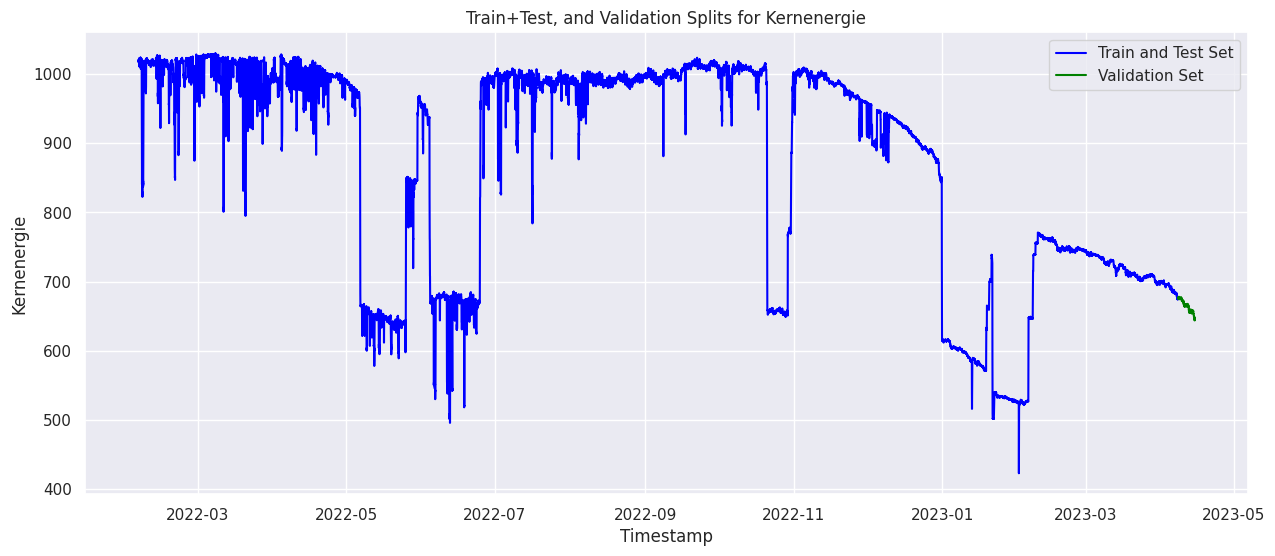

In [249]:
# Train, Test and Validation Splits
train_test_data = df_Kernenergie[:-672].copy()

# Split data into train, test, and validation sets
validation_data = df_Kernenergie[-672:]

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(train_test_data.index, train_test_data['Kernenergie'], label='Train and Test Set', color='blue')
plt.plot(validation_data.index, validation_data['Kernenergie'], label='Validation Set', color='green')

plt.title('Train+Test, and Validation Splits for Kernenergie')
plt.xlabel('Timestamp')
plt.ylabel('Kernenergie')
plt.legend()
plt.show()

In [250]:
f = Forecaster(y=train_test_data.Kernenergie,current_dates=train_test_data.index, freq='15min')

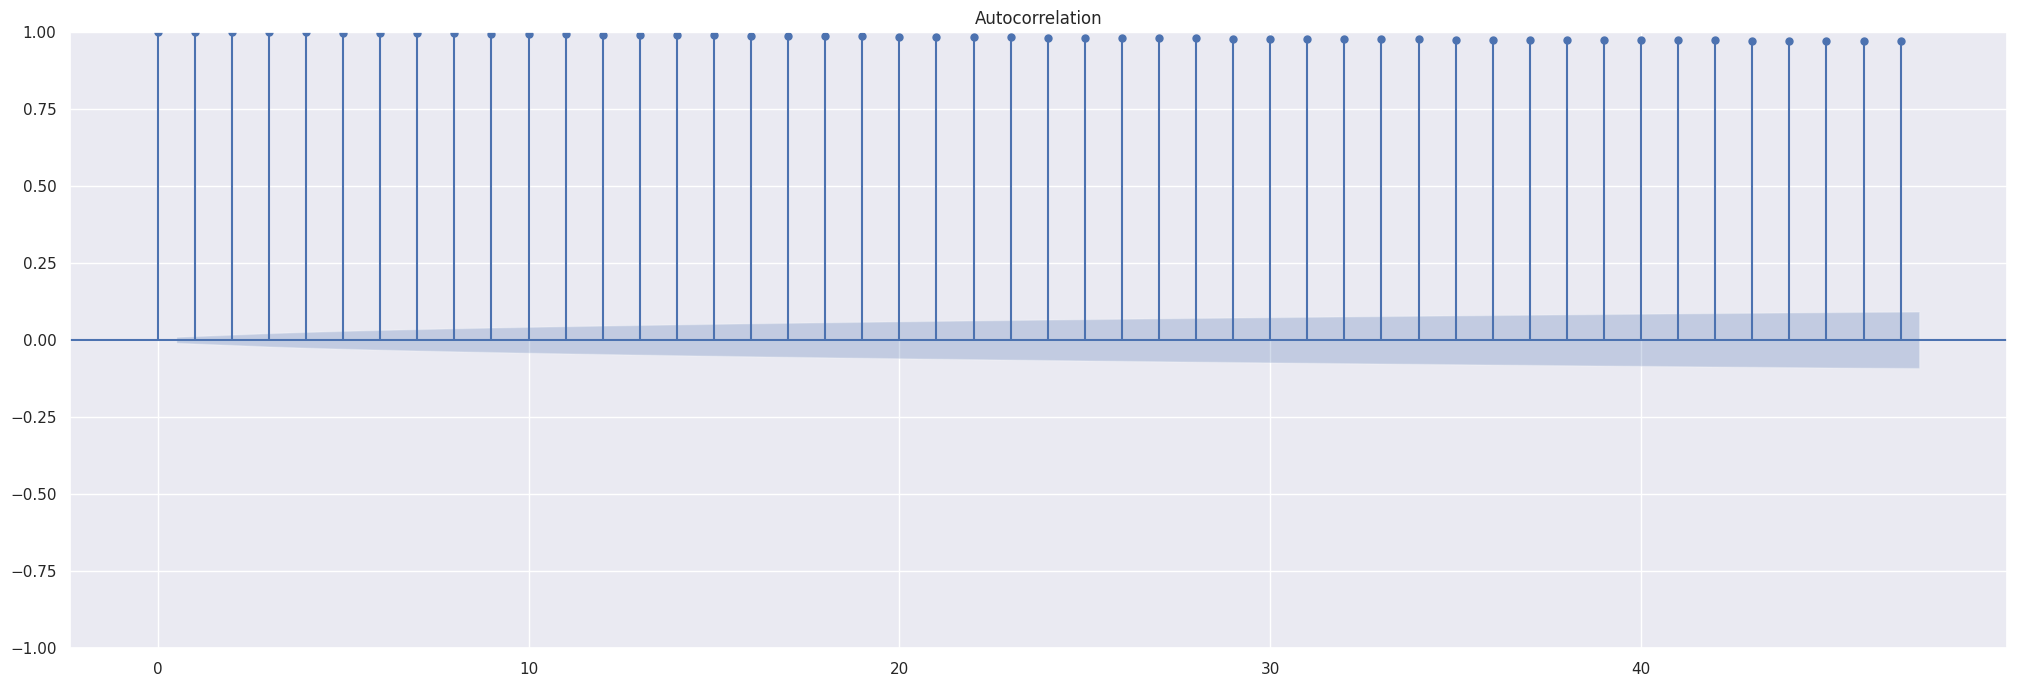

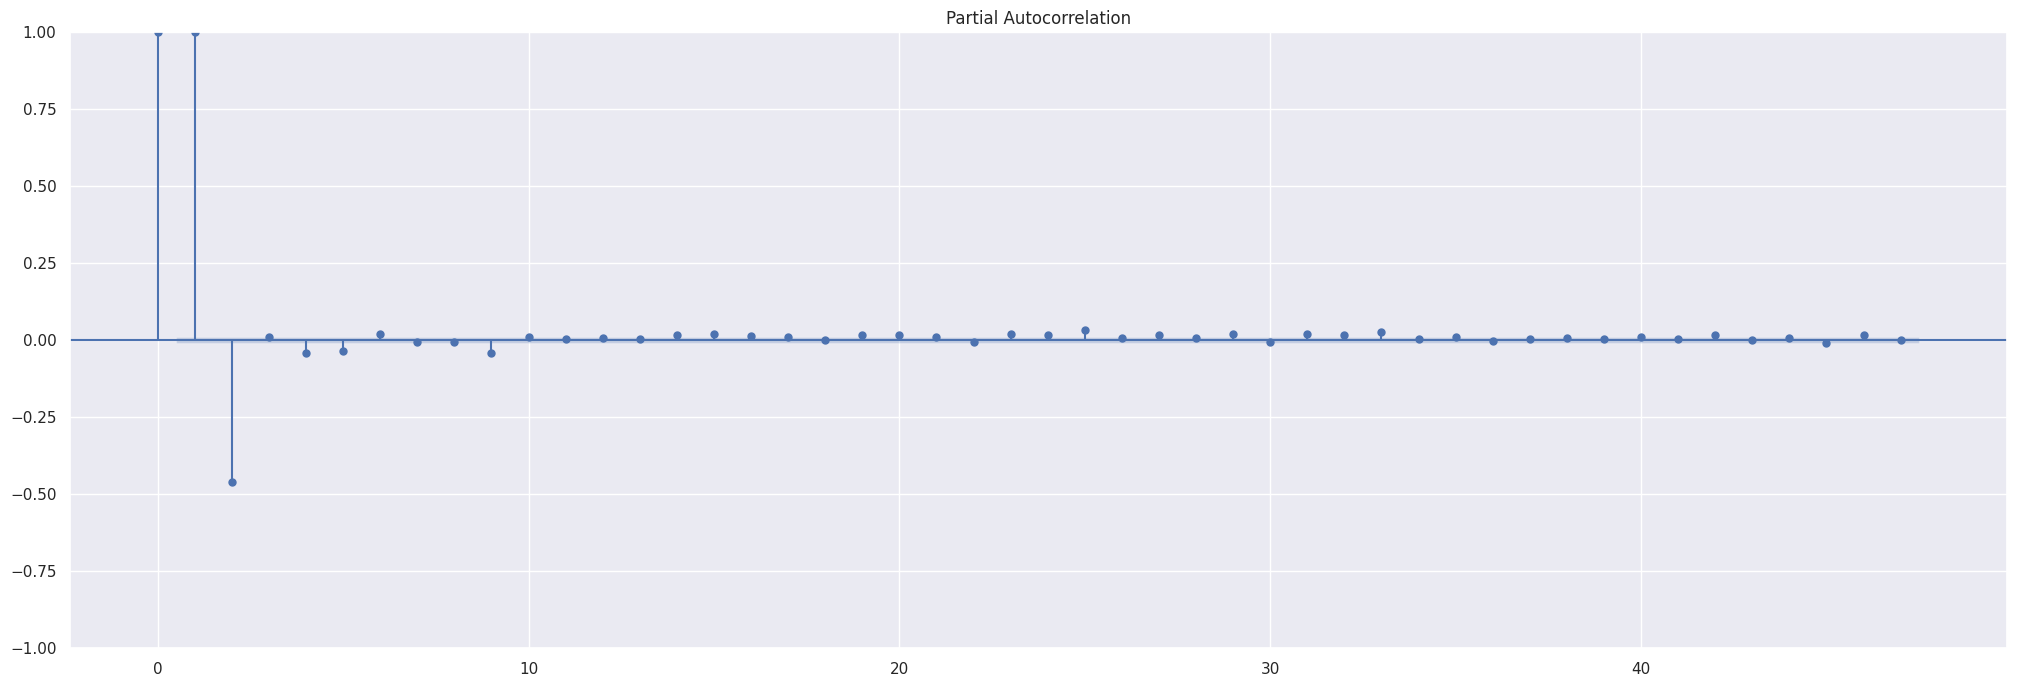

In [251]:
f.plot_acf()
f.plot_pacf()
plt.show()

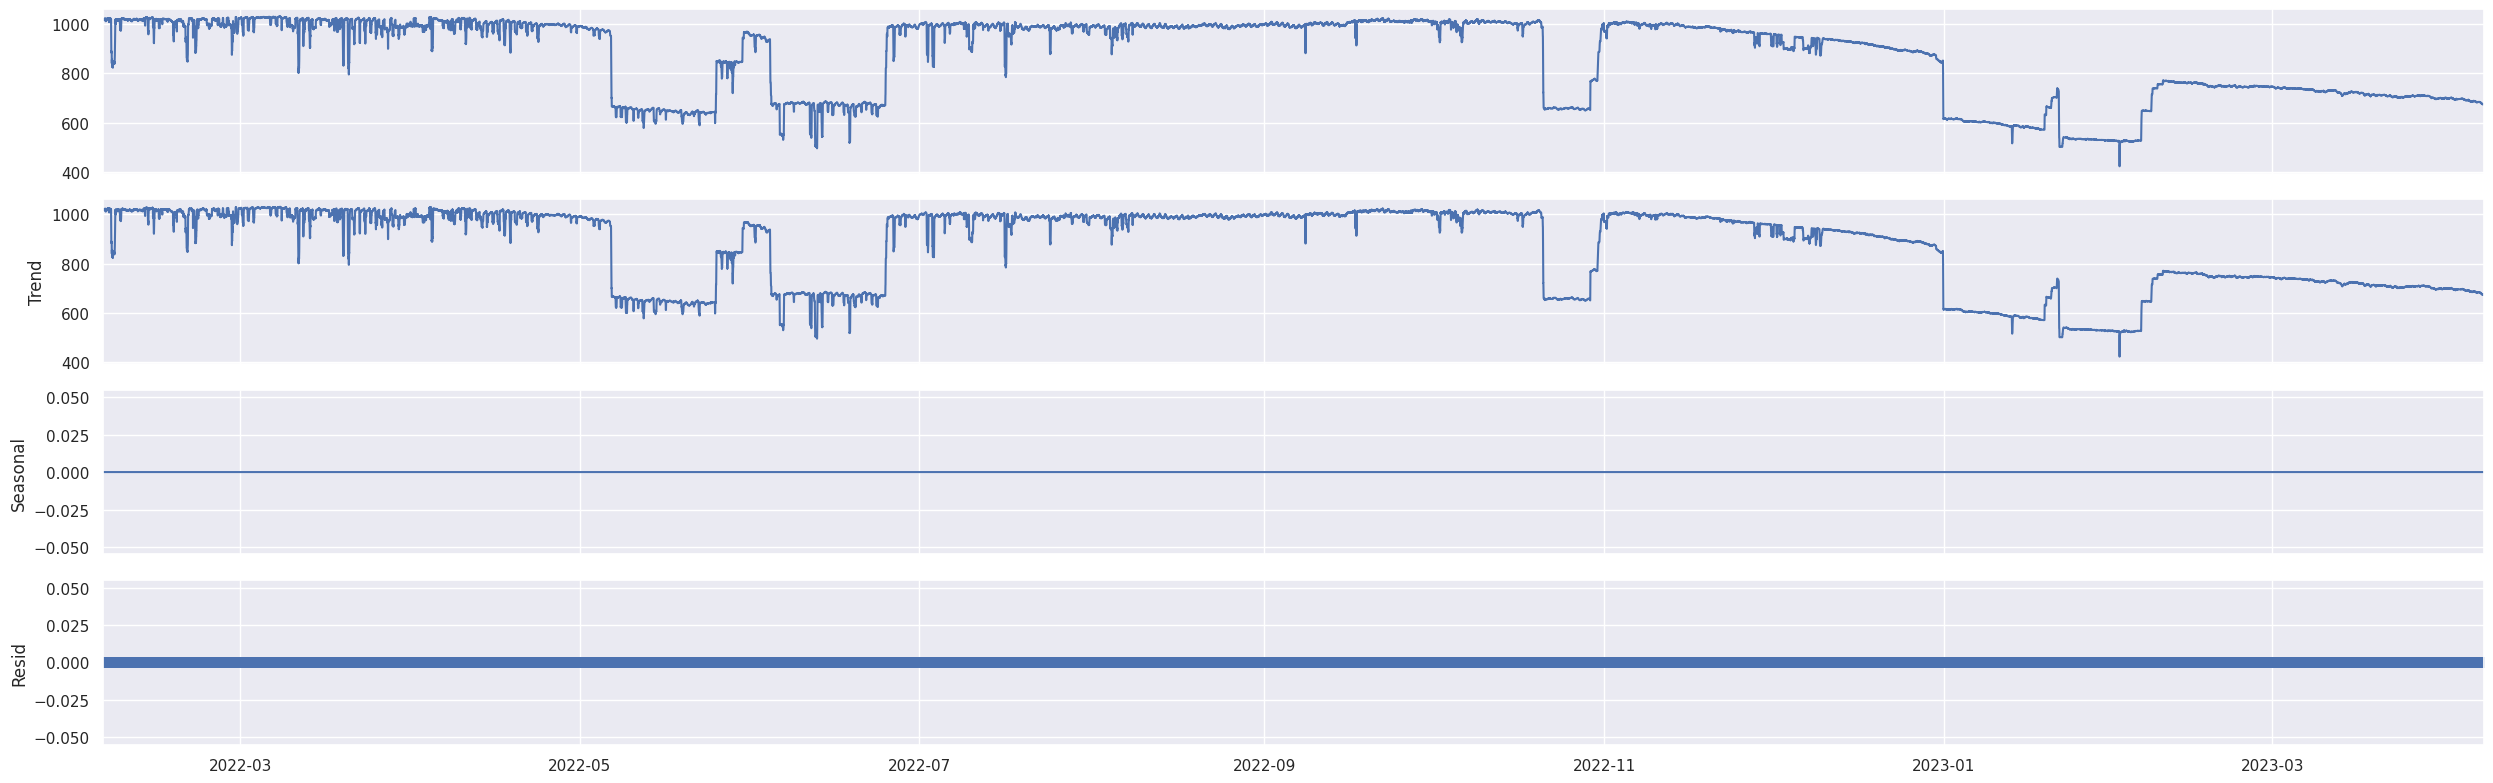

In [252]:
# Perform seasonal decomposition
result = seasonal_decompose(train_test_data, model='additive', extrapolate_trend='freq', period=1)

# Plot the decomposed components
result.plot()
plt.show()

In [253]:
is_stationary = f.adf_test(full_res=False)
print(is_stationary)

False


In [254]:
f.set_test_length(0.10)

In [255]:
f.eval_cis()

In [256]:
f.add_time_trend()

In [257]:
f.add_seasonal_regressors('month','quarter','week','dayofyear',raw=False,sincos=True)
f.add_seasonal_regressors('dayofweek','is_leap_year','week',raw=False,dummy=True,drop_first=True)
f.add_seasonal_regressors('year')

In [258]:
f.generate_future_dates(1344)
f.set_estimator('lstm')

Epoch 1/25
923/923 [==============================] - 17s 12ms/step - loss: 0.0554 - val_loss: 0.2625
Epoch 2/25
923/923 [==============================] - 10s 11ms/step - loss: 0.0429 - val_loss: 0.1911
Epoch 3/25
923/923 [==============================] - 10s 11ms/step - loss: 0.0394 - val_loss: 0.1370
Epoch 4/25
923/923 [==============================] - 10s 11ms/step - loss: 0.0379 - val_loss: 0.1327
Epoch 5/25
923/923 [==============================] - 10s 11ms/step - loss: 0.0375 - val_loss: 0.1212
Epoch 6/25
923/923 [==============================] - 10s 10ms/step - loss: 0.0375 - val_loss: 0.1486
Epoch 7/25
923/923 [==============================] - 9s 10ms/step - loss: 0.0365 - val_loss: 0.1911
Epoch 8/25
923/923 [==============================] - 10s 11ms/step - loss: 0.0366 - val_loss: 0.1221
Epoch 9/25
923/923 [==============================] - 9s 10ms/step - loss: 0.0355 - val_loss: 0.1032
Epoch 10/25
923/923 [==============================] - 9s 10ms/step - loss: 0.0351 -

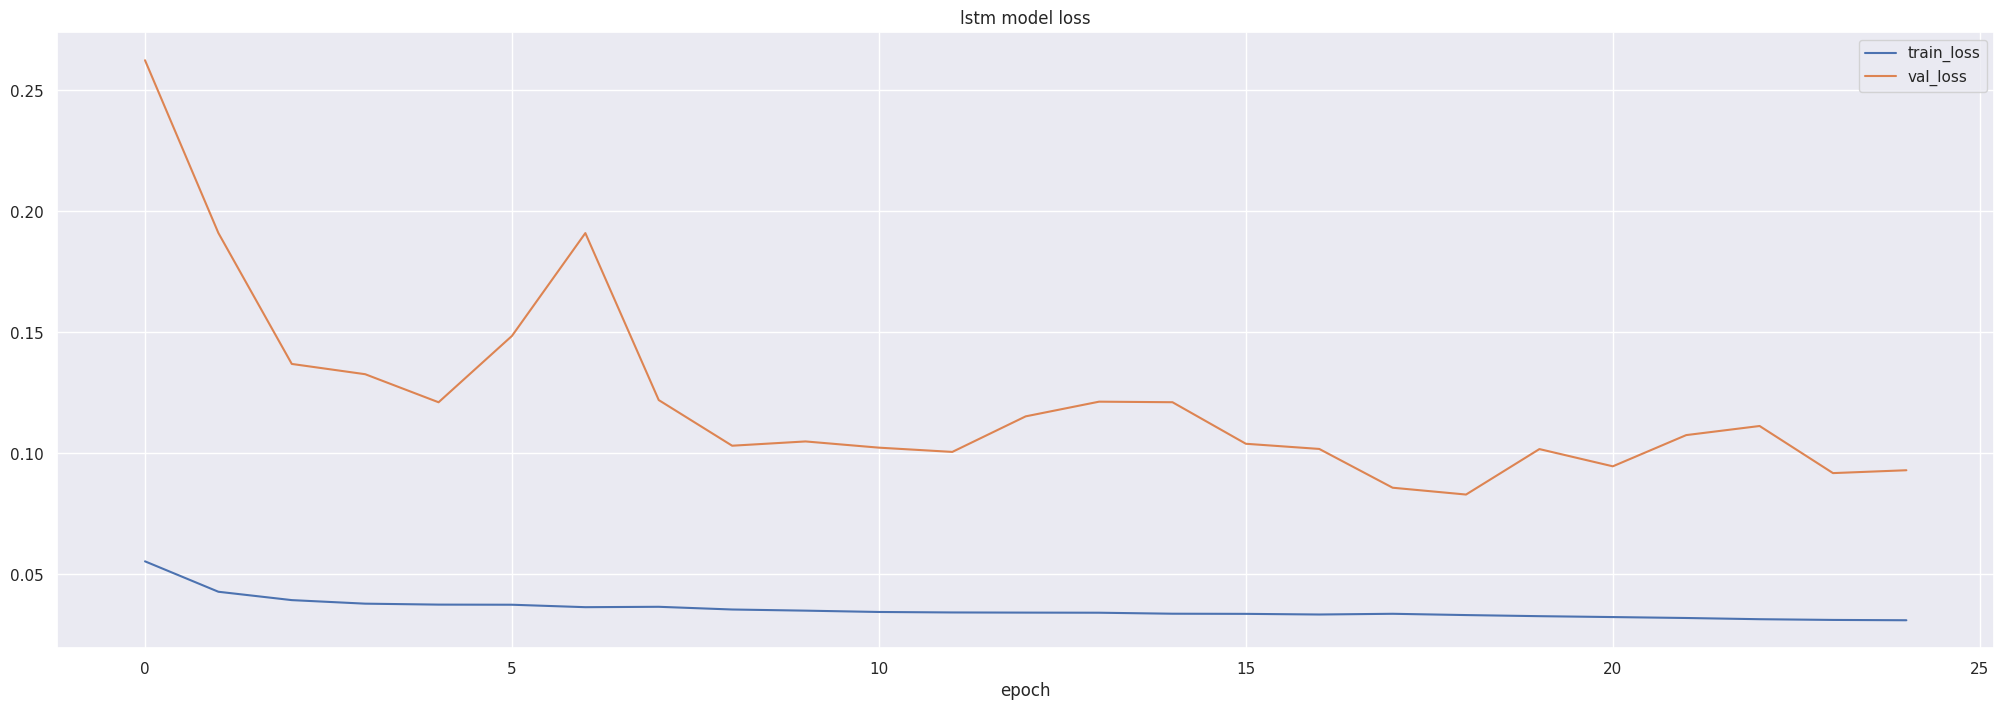

Epoch 1/25
1116/1116 [==============================] - 17s 11ms/step - loss: 0.0411 - val_loss: 0.0139
Epoch 2/25
1116/1116 [==============================] - 11s 10ms/step - loss: 0.0279 - val_loss: 0.0049
Epoch 3/25
1116/1116 [==============================] - 11s 10ms/step - loss: 0.0276 - val_loss: 0.0054
Epoch 4/25
1116/1116 [==============================] - 11s 10ms/step - loss: 0.0270 - val_loss: 0.0022
Epoch 5/25
1116/1116 [==============================] - 11s 10ms/step - loss: 0.0265 - val_loss: 0.0052
Epoch 6/25
1116/1116 [==============================] - 11s 10ms/step - loss: 0.0260 - val_loss: 0.0036
Epoch 7/25
1116/1116 [==============================] - 11s 10ms/step - loss: 0.0253 - val_loss: 0.0026
Epoch 8/25
1116/1116 [==============================] - 11s 10ms/step - loss: 0.0253 - val_loss: 0.0061
Epoch 9/25
1116/1116 [==============================] - 11s 10ms/step - loss: 0.0247 - val_loss: 0.0111
Epoch 10/25
1116/1116 [==============================] - 11s 10m

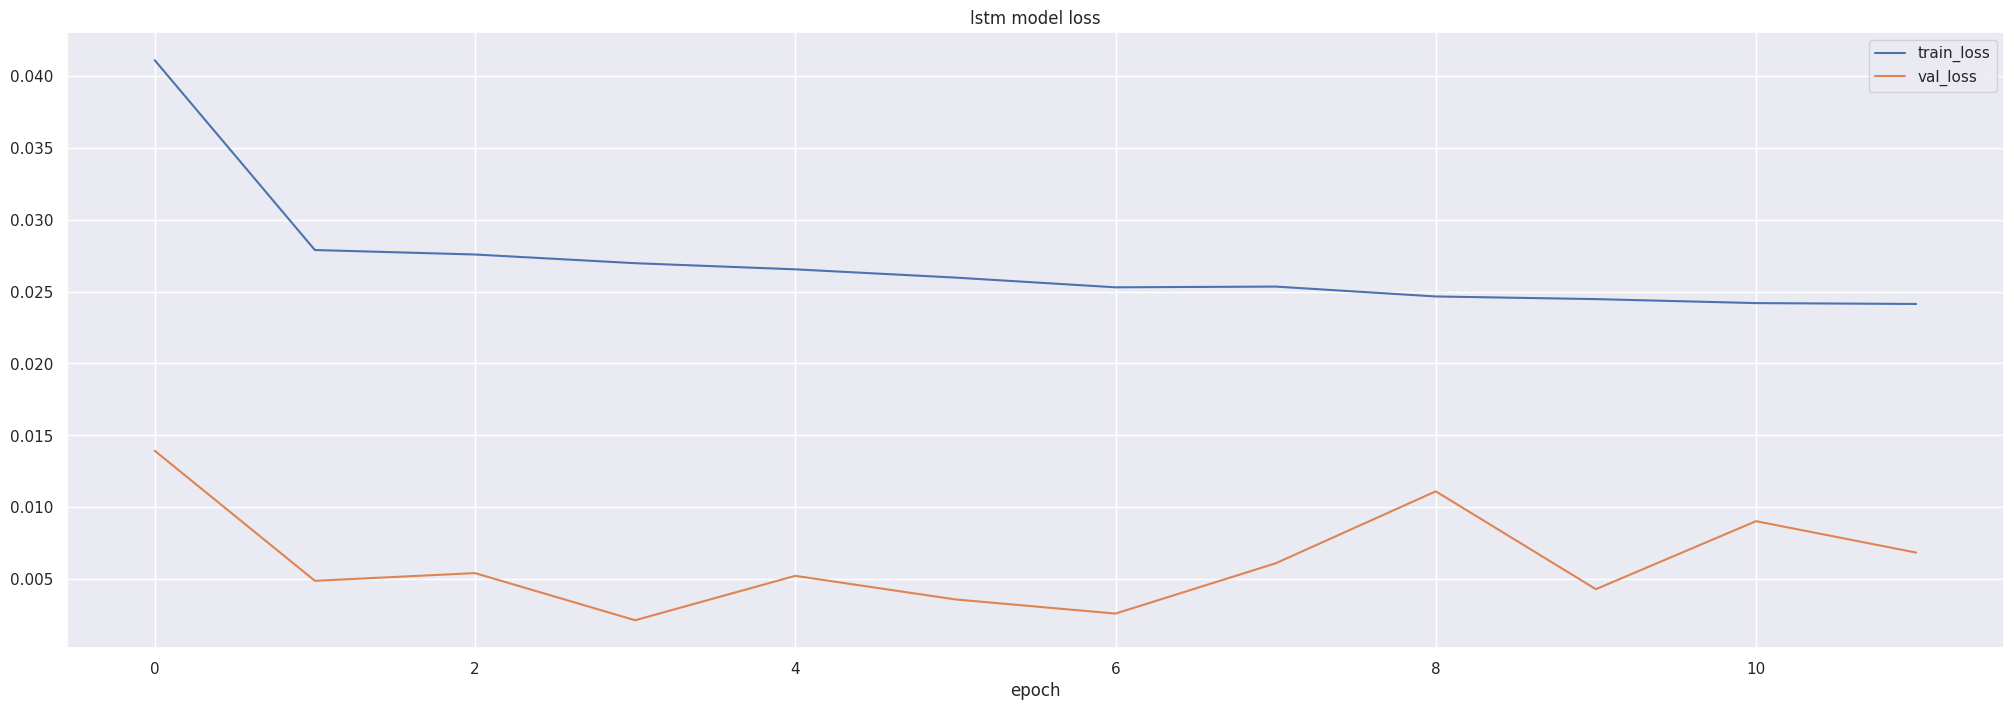

In [259]:
f.manual_forecast(call_me='lstm_best',
                  lags=36,
                  batch_size=32,
                  epochs=25,
                  validation_split=0.1,
                  activation='tanh',
                  optimizer='Adam',
                  learning_rate=0.001,
                  loss='mean_squared_error',
                  callbacks=EarlyStopping(monitor='val_loss',
                                          patience=8),
                  lstm_layer_sizes=(72,)*4,
                  dropout=(0,)*4,
                  plot_loss=True)

In [260]:
#import numpy as np

# Define the function to return the SMAPE value
def calculate_smape(actual, predicted) -> float:

    # Convert actual and predicted to numpy
    # array data type if not already
    if not all([isinstance(actual, np.ndarray),
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)

    return round(
        np.mean(
            np.abs(predicted - actual) /
            ((np.abs(predicted) + np.abs(actual))/2)
        )*100, 2
    )

Number of NaN values in 'lstm_best' column: 0
No NaN values in the 'lstm_best' column.
output is non-zero
Mean Absolute Percentage Error (MAPE) validation set vs prediction set : 8.89%
Mean Absolute Error (MAE) validation set vs prediction set : 58.54404188028448
Root Mean Squared Error (RMSE) validation set vs prediction set : 73.22958091530954


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


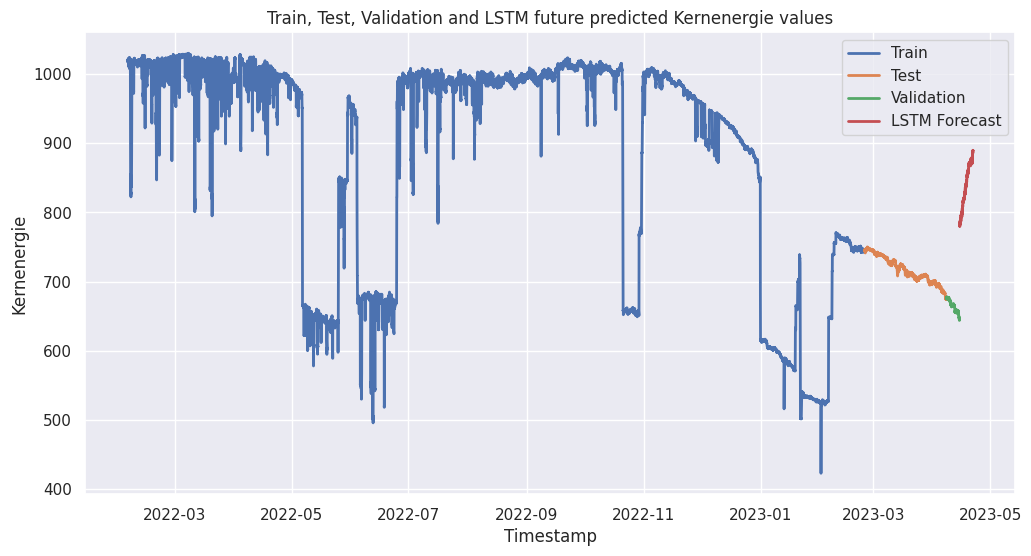

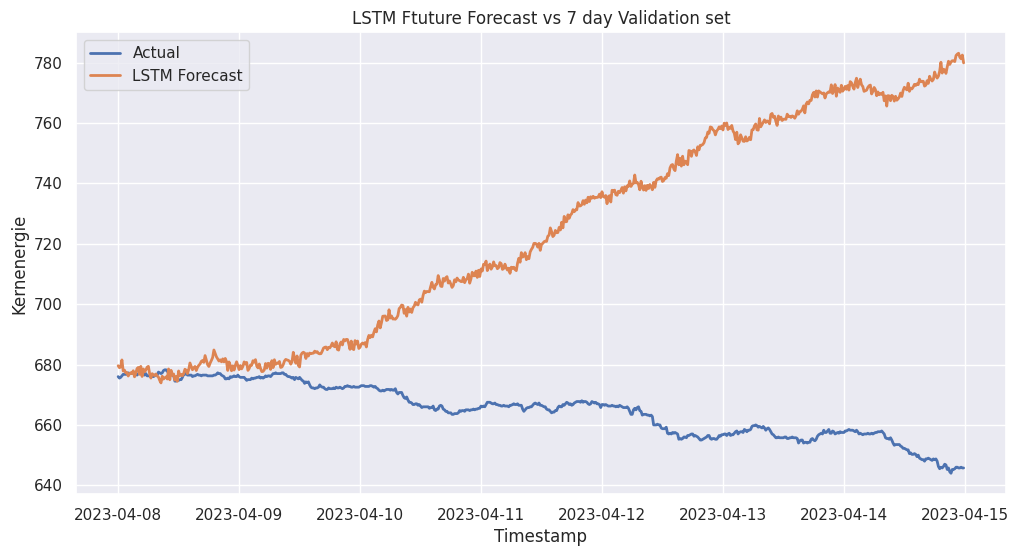

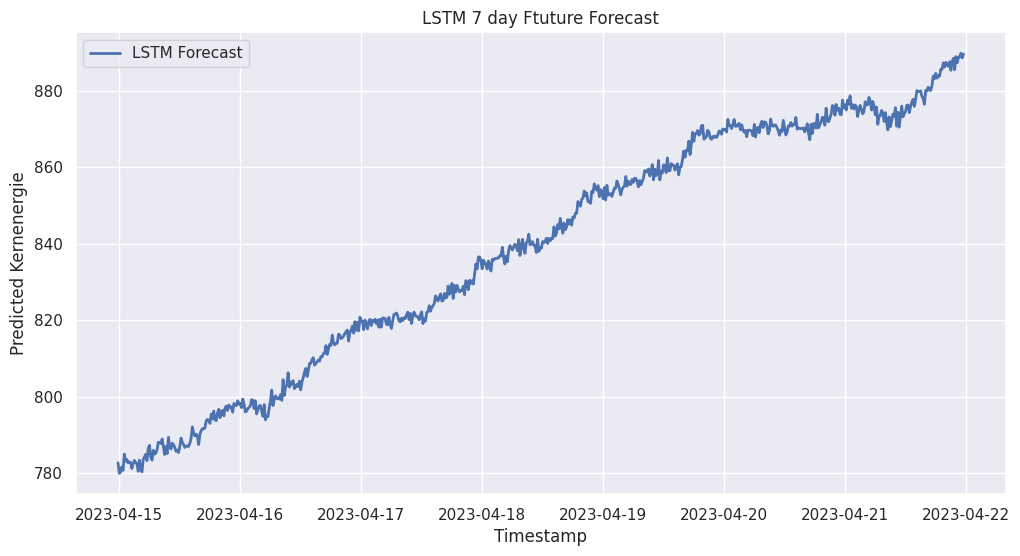

In [264]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

# Get fture forecast values and index
lstm_default_forecasted_df = f.export('lvl_fcsts')
last_timestamp = validation_data.index[-1]
new_index = pd.date_range(start=last_timestamp, periods=672, freq='15T')
existing_index_series = pd.Series(validation_data.index)
new_index_series = pd.Series(new_index)
concatenated_series = pd.concat([existing_index_series, new_index_series])
lstm_default_forecasted_df.index = concatenated_series


# Check for NaN in prediction
nan_count = lstm_default_forecasted_df["lstm_best"].isna().sum()
print("Number of NaN values in 'lstm_best' column:", nan_count)

if nan_count > 0:
    print("There are NaN values in the 'lstm_best' column.")
    # Optionally, print or handle the rows with NaN values
    print(lstm_default_forecasted_df[lstm_default_forecasted_df["lstm_best"].isna()])
else:
    print("No NaN values in the 'lstm_best' column.")

if (lstm_default_forecasted_df["lstm_best"] == 0).any():
  print("We have 0 values in lstm_best")
else:
  print("output is non-zero")


# Calculate Metrics
mae = mean_absolute_error(validation_data["Kernenergie"].values, lstm_default_forecasted_df["lstm_best"].values[:672])
mape = mean_absolute_percentage_error(validation_data["Kernenergie"].values, lstm_default_forecasted_df["lstm_best"].values[:672])
rmse = mean_squared_error(validation_data["Kernenergie"].values, lstm_default_forecasted_df["lstm_best"].values[:672], squared=False)
#smape = calculate_smape(validation_data["Photovoltaik"].values, lstm_default_forecasted_df["lstm_best"].values[:672])

# Print metrics
print(f'Mean Absolute Percentage Error (MAPE) validation set vs prediction set : {mape*100:.2f}%')
#print(f'Symmetric Mean Absolute Percentage Error (MAPE) validation set vs prediction set : {smape*100:.2f}%')
print(f'Mean Absolute Error (MAE) validation set vs prediction set : {mae}')
print(f'Root Mean Squared Error (RMSE) validation set vs prediction set : {rmse}')

# Split train_test_data into separate train and test sets and train_index and test_index
train_index, test_index = train_test_split(train_test_data.index, test_size=0.1, shuffle=False, random_state=42)
train,test = train_test_split(train_test_data["Kernenergie"], test_size=0.1, shuffle=False, random_state=42)


# Plotting train+test, validation and future predictions together
plt.figure(figsize=(12, 6))
plt.plot(train_index, train, label='Train', linewidth=2)
plt.plot(test_index, test, label='Test', linewidth=2)
plt.plot(validation_data.index, validation_data["Kernenergie"], label='Validation', linewidth=2)
plt.plot(lstm_default_forecasted_df.index[672:], lstm_default_forecasted_df["lstm_best"][672:], label='LSTM Forecast', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Kernenergie')
plt.title('Train, Test, Validation and LSTM future predicted Kernenergie values')
plt.legend()
plt.show()

# Plotting simulated future with validation
plt.figure(figsize=(12, 6))
plt.plot(validation_data.index, validation_data["Kernenergie"], label='Actual', linewidth=2)
plt.plot(validation_data.index, lstm_default_forecasted_df["lstm_best"][:672], label='LSTM Forecast', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Kernenergie')
plt.title('LSTM Ftuture Forecast vs 7 day Validation set')
plt.legend()
plt.show()

# Plotting real future
plt.figure(figsize=(12, 6))
plt.plot(lstm_default_forecasted_df.index[672:], lstm_default_forecasted_df["lstm_best"][672:], label='LSTM Forecast', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Predicted Kernenergie')
plt.title('LSTM 7 day Ftuture Forecast')
plt.legend()
plt.show()


In [265]:
last_672_rows = lstm_default_forecasted_df.tail(672)
result_df = pd.DataFrame({
    'Timestamp': last_672_rows.index,
    'Predicted_Kernenergie_Values': last_672_rows["lstm_best"].values
})

# Save the last 672 rows to a CSV file
last_672_rows.to_csv("Kernenergie_7_Days_Future_Forecast.csv", index=False)

In [266]:
first_672_rows = lstm_default_forecasted_df.tail(672)
result_df = pd.DataFrame({
    'Timestamp': validation_data.index,
    'Actual_Kernenergie_Values': validation_data["Kernenergie"].values,
    'Predicted_Kernenergie_Values': first_672_rows["lstm_best"].values
})

# Save the DataFrame to a CSV file
result_df.to_csv("Kernenergie_7_Days_Prediction_Validation_Data.csv", index=False)

In [267]:
validation_data.tail(160)

,Kernenergie
_time,
2023-04-13 08:00:00+00:00,659.50
2023-04-13 08:15:00+00:00,659.00
2023-04-13 08:30:00+00:00,658.25
2023-04-13 08:45:00+00:00,658.75
2023-04-13 09:00:00+00:00,659.00
...,...
2023-04-14 22:45:00+00:00,645.75
2023-04-14 23:00:00+00:00,645.75
2023-04-14 23:15:00+00:00,646.00
